In [1]:
import numpy as np
import astropy
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import glob
import pickle
from astropy.table import Table
import lmfit
from lmfit.models import VoigtModel
from scipy.interpolate import interp1d
from PyAstronomy import pyasl

import sys
from tqdm import tqdm
sys.path.append('../../../wdtools/')
sys.path.append('../../../../isochrones/')
from astropy.io import fits
import scipy
#plt.style.use('vedant')
from bisect import bisect_left
import lmfit
import isochrones
import wdtools
import matplotlib.gridspec as gridspec
sp = wdtools.SpecTools()
from scipy.ndimage import gaussian_filter
from matplotlib.ticker import FormatStrFormatter

halpha = 6564.61
hbeta = 4862.68
speed_light = 299792458 # m/s
radius_sun = 696340000 # m 
g_sun = 273.95 # m/s
pc_to_m = 3.086e+16
mass_sun = 1.9884e30
newton_G = 6.674e-11

na1 = 5889.6
na2 = 5895.7

mg = 5176.7

ca1 = 8500.36
ca2 = 8544.44
ca3 = 8664.52
ca2k = 3934.777
ca2h = 3969.58

import pyphot
from pyphot import unit
plt.rcParams.update({'font.size': 18})

plt.style.use('vedant')

Holoviews not imported. Some visualizations will not be available.
Using TensorFlow backend.
/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be 

In [2]:
lib = pyphot.get_library()
mean_wls = np.asarray([3596, 4639, 6122,7439,8896])
lamgrid = np.linspace(3100, 9900, 6000)
abs_distance = 10 # pc

## MPMS

In [3]:
import isochrones.mist
mist = isochrones.mist.MIST_Isochrone(bands = ['SDSS_u', 'SDSS_g', 'SDSS_r'])

In [4]:
sys.path.append('../../')
import read_mist_models

In [5]:
old_iso = read_mist_models.ISOCMD('../../mpms_mist.cmd')

Reading in: ../../mpms_mist.cmd


## WD

In [6]:
sys.path.append('../../../')
import WD_models
fontaine_model = WD_models.load_model('f', 'f', 'f', 'H')
g_acc = (10**fontaine_model['logg'])/100

rsun = np.sqrt(fontaine_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun

logg_teff_to_rsun = WD_models.interp_xy_z_func(x = fontaine_model['logg'], y = 10**fontaine_model['logteff'],\
                                                z = rsun, interp_type = 'linear')

In [7]:
interpwd = pickle.load(open('interp/interpwd.p', 'rb'))
def get_wd(teff, logg, wl):
    return 10**interpwd((logg, teff, np.log10(wl)))

In [8]:
abs_distance = 10
def get_cal_spec_wd(teff, logg):
    
    mfl = get_wd(teff, logg, lamgrid)

    radius = logg_teff_to_rsun(logg, teff) * radius_sun
    distance = abs_distance * pc_to_m

    solid_angle = 4 * np.pi * (radius / distance) ** 2

    mfl = solid_angle * mfl            #### ADD GP or EXTINCTION?
    mfl = 2.99e21 * (mfl/1000) * (1 /lamgrid**2)
    
    return mfl

In [9]:
def get_sdss_sed_wd(teff, logg, to_mag = False):
    fl = get_cal_spec_wd(teff, logg)
    if to_mag:
        fl = get_wd(teff, logg, lamgrid)
    wl = lamgrid * unit['AA']
    fl = fl * unit['erg/s/cm**2/Hz']
    sed = [];
    for band in ['u', 'g', 'r', 'i', 'z']:
        f = lib['SDSS_' + band]
        se = f.get_flux(wl, fl)
        sed.append(se)
    sed = np.asarray(sed)
    if to_mag:
        sed = -2.5 * np.log10(sed) - 48.60
    return sed

# Color-Color

In [10]:
teffs = np.linspace(4000, 10000, 100)
wd_seds = np.asarray([get_sdss_sed_wd(teff, 8, True) for teff in teffs])
wd_seds_7 = np.asarray([get_sdss_sed_wd(teff, 7, True) for teff in teffs])
wd_seds_9 = np.asarray([get_sdss_sed_wd(teff, 9, True) for teff in teffs])

# mpms_seds = np.asarray([get_sdss_sed_mpms(teff, 4.5, True) for teff in teffs])
# mpms_seds_3 = np.asarray([get_sdss_sed_mpms(teff, 3, True) for teff in teffs])
# mpms_seds_6 = np.asarray([get_sdss_sed_mpms(teff, 6, True) for teff in teffs])

In [11]:
wd_ug = wd_seds[:, 0] - wd_seds[:, 1]
# mpms_ug = mpms_seds[:, 0] - mpms_seds[:, 1]
wd_7_ug = wd_seds_7[:, 0] - wd_seds_7[:, 1]
# mpms_3_ug = mpms_seds_3[:, 0] - mpms_seds_3[:, 1]
wd_9_ug = wd_seds_9[:, 0] - wd_seds_9[:, 1]
# mpms_6_ug = mpms_seds_6[:, 0] - mpms_seds_6[:, 1]

In [12]:
wd_gr = wd_seds[:, 1] - wd_seds[:, 2]
# mpms_gr = mpms_seds[:, 1] - mpms_seds[:, 2]
wd_7_gr = wd_seds_7[:, 1] - wd_seds_7[:, 2]
# mpms_3_gr = mpms_seds_3[:, 1] - mpms_seds_3[:, 2]
wd_9_gr = wd_seds_9[:, 1] - wd_seds_9[:, 2]
# mpms_6_gr = mpms_seds_6[:, 1] - mpms_seds_6[:, 2]

## Overlay SDSS

In [13]:
table = Table.read('tables/lr_class.fits')
table['g-r'] = table['g_0'] - table['r_0']
table['u-g'] = table['u_0'] - table['g_0']

In [14]:
clean = (
    (table['g-r'] != 0)*
    (table['g-r'] > -0.25)*
    (table['g-r'] < 2)*
    (table['u-g'] < 2)*
    (table['u-g'] > 0)
)

mpms = table['ty'] == 'sdA/F'
da = table['ty'] == 'DA'

In [15]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [16]:
cids = [3890626773968983296]
candidates = [find_nearest(table['source_id'], id) for id in cids]

10.0


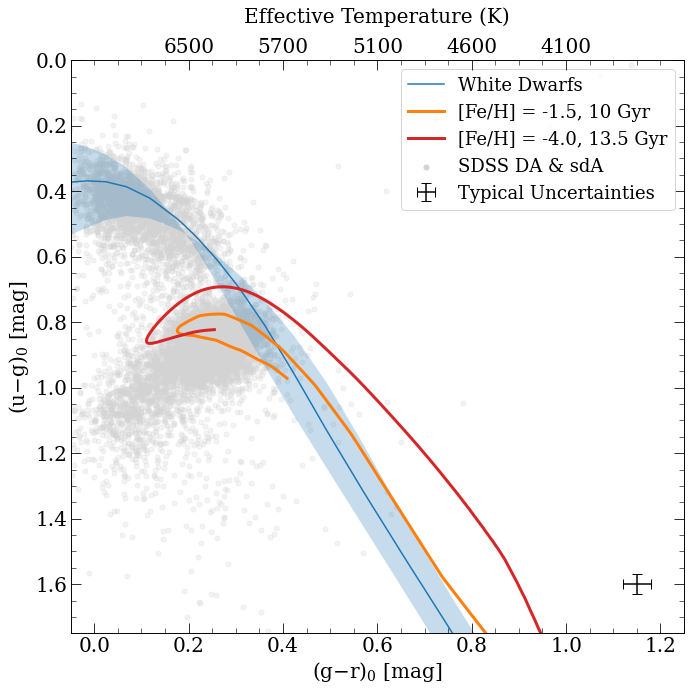

In [27]:
plt.rcParams.update({'font.size': 20})


plt.figure(figsize = (10, 10))

plt.scatter(table[clean*mpms]['g-r'], table[clean*mpms]['u-g'], 
            color = 'lightgrey', s = 25, alpha = 0.25, label = 'SDSS DA & sdA')
plt.scatter(table[clean*da]['g-r'], table[clean*da]['u-g'], 
            color = 'lightgrey', s = 25, alpha = 0.25)
# plt.scatter(table[candidates]['g-r'], table[candidates]['u-g'], s = 75, alpha = 1, 
#            label = 'Caffau\'s Star', marker = '*', color = 'r')

args = dict(color = 'C0')
plt.plot(wd_gr, wd_ug, **args, linestyle = '-', label = 'White Dwarfs', linewidth = 1.5)
# plt.plot(wd_7_gr, wd_7_ug, **args, linestyle = '--', linewidth = 1)
# plt.plot(wd_9_gr, wd_9_ug, **args, linestyle = '--', linewidth = 2)
plt.fill_between(wd_gr, wd_7_ug, wd_9_ug, alpha = 0.25)

args = dict(color = 'C1')
age_gyr = 10
log_age = np.log10(age_gyr * 1e9)
print(log_age)
iso = mist.isochrone(log_age, -1.5)
mask = (iso['eep'] > 202) & (iso['eep'] < 605) & (iso['logg'] > 3.5)
mpms_ug = np.asarray(iso['SDSS_u_mag'] - iso['SDSS_g_mag'])[mask]
mpms_gr = np.asarray(iso['SDSS_g_mag'] - iso['SDSS_r_mag'])[mask]
plt.plot(mpms_gr, mpms_ug, **args, label = '[Fe/H] = -1.5, 10 Gyr', linewidth = 3)

args = dict(color = 'C3')
mask = (old_iso.isocmds[0]['log_g'] > 3.5)
mpms_ug = np.asarray(old_iso.isocmds[0]['SDSS_u'] - old_iso.isocmds[0]['SDSS_g'])[mask]
mpms_gr = np.asarray(old_iso.isocmds[0]['SDSS_g'] - old_iso.isocmds[0]['SDSS_r'])[mask]
plt.plot(mpms_gr, mpms_ug, **args, label = '[Fe/H] = -4.0, 13.5 Gyr', linewidth = 3)

# age_gyr = 13.5
# log_age = np.log10(age_gyr * 1e9)
# print(log_age)
# iso = mist.isochrone(log_age, -3.5)
# mask = (iso['eep'] > 202) & (iso['eep'] < 605) & (iso['logg'] > 3.9)
# mpms_ug = np.asarray(iso['SDSS_u_mag'] - iso['SDSS_g_mag'])[mask]
# mpms_gr = np.asarray(iso['SDSS_g_mag'] - iso['SDSS_r_mag'])[mask]
# plt.plot(mpms_gr, mpms_ug, **args, label = '[Fe/H] = -3.5, 13.5 Gyr', linewidth = 1.5)

plt.errorbar(1.15,1.6, yerr = 0.03, xerr = 0.03, color = 'black', ecolor = 'k', capsize = 5,
            label = 'Typical Uncertainties', linestyle = 'none')

leg = plt.legend(fontsize = 18, loc=1)

for lh in leg.legendHandles: 
    lh.set_alpha(1)

plt.xlabel('(g$-$r)$_0$ [mag]')
plt.ylabel('(u$-$g)$_0$ [mag]')
plt.gca().invert_yaxis()

plt.xlim(-0.05, 1.25)
plt.ylim(1.75, 0)

c1 = 2.5
c2 = -0.4
grgrid = np.linspace(0, 1, 100)
#plt.plot(grgrid, c1 * grgrid + c2)


ticklocs = [0.2, 0.4, 0.6, 0.8, 1]
ax = plt.gca()
axtop = ax.twiny()

tickfunc = interp1d(mpms_gr, 10**old_iso.isocmds[0]['log_Teff'][mask])
axtop.set_xlim(ax.get_xlim())
axtop.set_xticks(ticklocs)
axtop.set_xticklabels(np.round(tickfunc(ticklocs), -2).astype(int))
axtop.set_xlabel('Effective Temperature (K)' , labelpad = 15)

plt.savefig('fig/theory_color_color.pdf', bbox_inches = 'tight')